# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline

# Tensorflow backend initialization

In [2]:
"""
Setup multi GPU usage

Example usage:
model = Sequential()
...
multi_model = multi_gpu_model(model, gpus=num_gpu)
multi_model.fit()

About memory usage:
https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
"""
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib

# IMPORTANT: Tells tf to not occupy a specific amount of memory
from keras.backend.tensorflow_backend import set_session  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
sess = tf.Session(config=config)  
set_session(sess)  # set this TensorFlow session as the default session for Keras.


# getting the number of GPUs 
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type    == 'GPU']
num_gpu = len(get_available_gpus())
print('Amount of GPUs available: %s' % num_gpu)

/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Amount of GPUs available: 4


# Function definitions

In [3]:
def reduce_memory(df):
    """
    Reduces memory footprint of the input dataframe.
    Changes float64 columns to float32 dtype.
    """
    columns = df.columns
    memory_before = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB

    for column in tqdm(columns):
        if df[column].dtype == 'float64':
            df[column] = df[column].astype('float32')
        
    memory_after = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB
    print('Memory uasge reduced from %.3f GB to %.3f GB' % (memory_before, memory_after))
    
    return df

# Preparing dataframe for preprocessing

In [4]:
%%time
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])

CPU times: user 528 ms, sys: 52.9 ms, total: 581 ms
Wall time: 551 ms


In [5]:
#df = reduce_memory(df_10s) # converts float64 to float32
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,gasPower,DD,DR,...,Q,RG,SQ,T,T10,TD,U,VV,WW,dwelling
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-07 15:00:00,625.004578,0.0,359.501007,0.0,192.500000,0.0,307.44101,0.0,305.450012,0.0,...,319.000000,0.0,7.631617,8.733334,9.133333,4.883333,76.500000,31916.666016,1.333333,P01S01W7548
2017-03-07 16:00:00,625.212280,0.0,359.501007,0.0,383.994446,0.0,307.44101,0.0,288.200012,0.0,...,391.000000,0.0,10.000000,9.116667,10.750000,5.416667,77.166664,23800.000000,2.666667,P01S01W7548
2017-03-07 17:00:00,625.578430,0.0,359.501007,0.0,277.722229,0.0,307.44101,0.0,285.866669,0.0,...,179.000000,0.0,2.936100,7.866667,8.450000,4.550000,78.833336,22233.333984,1.000000,P01S01W7548
2017-03-07 18:00:00,625.763977,0.0,359.501007,0.0,143.624283,0.0,307.44101,0.0,286.633331,0.0,...,65.833336,0.0,5.000000,7.066667,6.816667,4.433333,82.833336,20266.666016,2.500000,P01S01W7548
2017-03-07 19:00:00,625.877808,0.0,359.501007,0.0,143.376038,0.0,307.44101,0.0,278.783325,0.0,...,7.500000,0.0,0.000000,6.616667,6.016667,4.300000,84.666664,17433.333984,2.833333,P01S01W7548


In [6]:
df.describe()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,gasPower,DD,DR,...,P,Q,RG,SQ,T,T10,TD,U,VV,WW
count,116310.000000,116310.000000,116310.000000,116310.000000,116310.000000,116310.000000,116159.000000,115271.000000,126879.000000,126918.000000,...,126885.000000,126918.000000,126918.000000,126918.000000,126918.000000,126918.000000,126918.000000,126918.000000,126918.000000,126918.000000
mean,2254.009894,734.602074,2553.808870,337.142188,306.854612,91.833729,1910.555321,0.082981,200.732522,36.635836,...,1017.346305,164.890896,0.089398,2.618587,12.659400,12.065308,8.592021,77.504207,25513.388346,10.695239
std,1438.333101,1568.532075,1568.656696,715.891360,306.335392,385.189732,963.505715,0.180611,86.342213,116.541015,...,7.774604,223.271878,0.504380,3.761346,5.287665,6.282919,4.399467,14.602729,12841.003032,16.725095
min,23.594465,0.000000,32.388000,0.000000,0.000000,0.000000,195.725006,0.000000,1.850000,0.000000,...,985.966675,0.000000,0.000000,0.000000,-1.700000,-5.916667,-3.133333,30.333334,142.333328,0.000000
25%,1174.895020,0.000000,1284.309570,0.000000,127.944202,0.000000,1121.953003,0.000000,143.366669,0.000000,...,1012.539978,0.166667,0.000000,0.000000,8.950000,8.083333,4.950000,67.333336,14900.000000,1.833333
50%,1730.750732,0.000000,2058.964233,0.000000,213.964706,0.000000,1729.171997,0.008057,219.949997,0.000000,...,1017.599976,34.166668,0.000000,0.000000,12.283334,11.816667,8.760000,79.666664,25966.666016,2.333333
75%,2886.669312,760.737244,3856.920044,301.908363,377.012100,0.000000,2664.135010,0.069092,262.466675,0.000000,...,1022.833313,294.666656,0.000000,5.212033,16.450001,16.183332,12.233334,89.500000,35783.332031,10.000000
max,6218.289062,7923.427246,7707.495117,3508.043945,4240.345703,5999.823242,4668.230957,2.692017,356.816650,600.000000,...,1037.833374,926.500000,18.166666,10.000000,30.683332,32.466667,20.383333,100.000000,49900.000000,81.800003


# Preprocessing

In [7]:
from sklearn import preprocessing

pd.options.mode.chained_assignment = None
np.random.seed(1234)

def drop_duplicates(df):
    print("Number of duplicates: {}".format(len(df.index.get_duplicates())))
    return df[~df.index.duplicated(keep='first')]
    
def impute_missing(df):
    # todo test with moving average / mean or something smarter than forward fill
    print("Number of rows with nan: {}".format(np.count_nonzero(df.isnull())))
    df.fillna(method='ffill', inplace=True)
    return df
    
def first_order_difference(data, columns):
    for column in columns:
        data[column+'_d'] = data[column].diff(periods=1)
    
    return data.dropna()

def derive_prediction_columns(data, column, horizons):
    for look_ahead in horizons:
        data['prediction_' + str(look_ahead)] = data[column].diff(periods=look_ahead).shift(-look_ahead)
    
    return data.dropna()

def scale_features(scaler, features):
    scaler.fit(features)
    
    scaled = scaler.transform(features)
    scaled = pd.DataFrame(scaled, columns=features.columns)
    
    return scaled

def inverse_prediction_scale(scaler, predictions, original_columns, column):
    loc = original_columns.get_loc(column)
    
    inverted = np.zeros((len(predictions), len(original_columns)))
    inverted[:,loc] = np.reshape(predictions, (predictions.shape[0],))
    
    inverted = scaler.inverse_transform(inverted)[:,loc]
    
    return inverted

def invert_all_prediction_scaled(scaler, predictions, original_columns, horizons):
    inverted = np.zeros(predictions.shape)
    
    for col_idx, horizon in enumerate(horizons):
        inverted[:,col_idx] = inverse_prediction_scale(
            scaler, predictions[:,col_idx], 
            original_columns,
            "prediction_" + str(horizon))
        
    return inverted

def inverse_prediction_difference(predictions, original):
    return predictions + original

def invert_all_prediction_differences(predictions, original):
    inverted = predictions
    
    for col_idx, horizon in enumerate(horizons):
        inverted[:, col_idx] = inverse_prediction_difference(predictions[:,col_idx], original)
        
    return inverted

In [8]:
dataset = drop_duplicates(df)
dataset = impute_missing(dataset)

#select features we're going to use
features = dataset[['ePower', 'DD', 'FF', 'N', 'Q', 'RG', 'T', 'U']]

# the time horizons we're going to predict (in hours)
horizons = [1, 6, 12, 24]

features = first_order_difference(features, features.columns)
features = derive_prediction_columns(features, 'FF', horizons)

scaler = preprocessing.StandardScaler()
scaled = scale_features(scaler, features)

scaled.describe()

Number of duplicates: 6766
Number of rows with nan: 9670


,ePower,DD,FF,N,Q,RG,T,U,ePower_d,DD_d,FF_d,N_d,Q_d,RG_d,T_d,U_d,prediction_1,prediction_6,prediction_12,prediction_24
count,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03,6.742000e+03
mean,5.574540e-16,-1.251594e-16,1.253488e-16,7.843029e-16,-1.780194e-15,9.868997e-16,-7.371077e-16,-4.099690e-16,3.581630e-18,1.124714e-17,-4.248554e-18,-2.762384e-17,-1.066583e-17,7.476202e-19,2.116044e-17,3.231701e-18,-1.655372e-17,-8.521810e-18,1.626966e-17,-1.630259e-18
std,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00
min,-1.364053e+00,-2.576694e+00,-1.719718e+00,-1.404811e+00,-6.970709e-01,-2.005439e-01,-2.821695e+00,-3.469619e+00,-9.541238e+00,-8.008392e+00,-6.588333e+00,-3.918421e+00,-8.258100e+00,-2.520149e+01,-1.687002e+01,-9.618483e+00,-6.588261e+00,-3.914840e+00,-4.549679e+00,-5.121136e+00
25%,-6.550285e-01,-5.215156e-01,-7.617805e-01,-1.194718e+00,-6.962972e-01,-2.005439e-01,-7.268147e-01,-6.638037e-01,-1.671773e-01,-1.623440e-01,-5.533517e-01,-2.615776e-01,-1.751082e-01,-6.511630e-19,-4.988388e-01,-5.126873e-01,-5.532996e-01,-6.431330e-01,-6.474076e-01,-6.229991e-01
50%,-1.765486e-01,2.035798e-01,-1.338532e-01,3.284536e-01,-5.868130e-01,-2.005439e-01,1.808337e-02,1.361521e-01,-1.243476e-04,1.139685e-02,-5.716653e-03,-3.745125e-04,5.655473e-04,-6.511630e-19,-3.374899e-02,-7.159847e-04,-6.326188e-03,3.432686e-02,3.232712e-03,-3.859763e-03
75%,2.426788e-01,6.773361e-01,5.833443e-01,9.587314e-01,4.737909e-01,-2.005439e-01,7.202606e-01,8.047722e-01,1.441562e-01,1.985938e-01,5.501658e-01,2.608286e-01,2.181613e-01,-6.511630e-19,4.485684e-01,5.112562e-01,5.502142e-01,6.441442e-01,6.676213e-01,6.328572e-01
max,9.837927e+00,1.903296e+00,4.727001e+00,1.431440e+00,3.604149e+00,3.034254e+01,3.215164e+00,1.521151e+00,9.438599e+00,7.810349e+00,1.201366e+01,4.178875e+00,8.927989e+00,2.590784e+01,1.676119e+01,6.845087e+00,1.201367e+01,4.956720e+00,3.922944e+00,4.019212e+00


In [9]:
def prepare_test_train(data, features, predictions, sequence_length, split_percent=0.9):
    
    num_features = len(features)
    num_predictions = len(predictions)
    
     # make sure prediction cols are at end
    columns = features + predictions
    
    data = data[columns].values
    
    print("Using {} features to predict {} horizons".format(num_features, num_predictions))
    
    result = []
    for index in range(len(data) - sequence_length+1):
        result.append(data[index:index + sequence_length])

    result = np.array(result)
    # shape (n_samples, sequence_length, num_features + num_predictions)
    print("Shape of data: {}".format(np.shape(result)))
    
    row = round(split_percent * result.shape[0])
    train = result[:row, :]
    
    X_train = train[:, :, :-num_predictions]
    y_train = train[:, -1, -num_predictions:]
    X_test = result[row:, :, :-num_predictions]
    y_test = result[row:, -1, -num_predictions:]
    
    print("Shape of X train: {}".format(np.shape(X_train)))
    print("Shape of y train: {}".format(np.shape(y_train)))
    print("Shape of X test: {}".format(np.shape(X_test)))
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))
    
    y_train = np.reshape(y_train, (y_train.shape[0], num_predictions))
    y_test = np.reshape(y_test, (y_test.shape[0], num_predictions))
    
    return X_train, y_train, X_test, y_test, row

In [10]:
sequence_length = 48

prediction_cols = ['prediction_' + str(h) for h in horizons]
feature_cols = ['ePower', 'DD', 'FF', 'N', 'Q', 'RG', 'T', 'U']

X_train, y_train, X_test, y_test, row_split = prepare_test_train(
    scaled,
    feature_cols,
    prediction_cols,
    sequence_length,
    split_percent = 0.9)

Using 8 features to predict 4 horizons
Shape of data: (6695, 48, 12)
Shape of X train: (6026, 48, 8)
Shape of y train: (6026, 4)
Shape of X test: (669, 48, 8)


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#(-1 is because we only take the last y row in each sequence)
sequence_offset = sequence_length  - 1

# validate train
inverse_scale = invert_all_prediction_scaled(scaler, y_train, scaled.columns, horizons)

assert(mean_squared_error(
    features[prediction_cols][sequence_offset:row_split+sequence_offset], 
    inverse_scale) < 1e-10)


undiff_prediction = invert_all_prediction_differences(
    inverse_scale, 
    features['FF'][sequence_offset:row_split+sequence_offset])

for i, horizon in enumerate(horizons):
    assert(mean_squared_error(
        features['FF'][sequence_offset+horizon:row_split+sequence_offset+horizon], 
        undiff_prediction[:,i]) < 1e-10)

    
# validate test
inverse_scale = invert_all_prediction_scaled(scaler, y_test, scaled.columns, horizons)

assert(mean_squared_error(
    features[prediction_cols][sequence_offset+row_split:], 
    inverse_scale) < 1e-10)

undiff_prediction = invert_all_prediction_differences(
    inverse_scale, 
    features['FF'][sequence_offset+row_split:])

for i, horizon in enumerate(horizons):
    assert(mean_squared_error(
        features['FF'][sequence_offset+row_split+horizon:], 
        undiff_prediction[:-horizon,i]) < 1e-10)

# Keras

In [12]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop

def build_model(layers):
    model = Sequential()
    
    model.add(LSTM(
            layers[1],
            input_shape=(None, layers[0]),
            return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[2], return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[3], return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(layers[4], activation="linear"))
    
    model = multi_gpu_model(model, gpus=num_gpu)
    model.compile(loss="mse", optimizer='nadam')
    
    print(model.summary())
          
    return model

In [13]:
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

def run_network(X_train, y_train, X_test, layers, epochs, batch_size=512):
    model = build_model(layers)
    history = None
    
    try:
        history = model.fit(
            X_train, y_train, 
            batch_size=batch_size, 
            epochs=epochs, 
            validation_split=0.1,
            callbacks=[
                TensorBoard(log_dir='/tmp/tensorboard', write_graph=True), PlotLossesKeras()
                #EarlyStopping(monitor='val_loss', patience=5, mode='auto')
            ])
    except KeyboardInterrupt:
        print("\nTraining interrupted")
    
    predicted = model.predict(X_test)
    
    return model, predicted, history

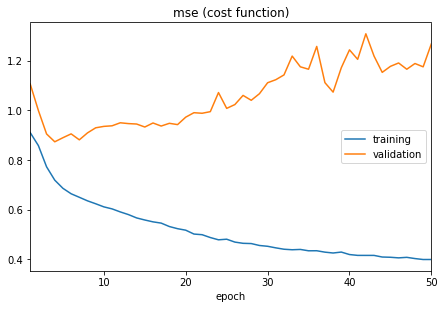

5423/5423 [==============================] - 4s 663us/step - loss: 0.3994 - val_loss: 1.2677


In [15]:
model, predicted, history = run_network(
    X_train, 
    y_train, 
    X_test,
    layers=[X_train.shape[2], 20, 15, 20, y_train.shape[1]],
    epochs=50)